In [ ]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords;
from gensim.models import ldamodel
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;
!pip install -U gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter
import matplotlib.pyplot as plt 
import resource
import tracemalloc


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('drive/My Drive/abcnews-date-text.csv', error_bad_lines=False);
headlines = data[['headline_text']]
headlines = headlines.astype('str')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
def tokenize_words(txt):
  tokenized= word_tokenize(txt)
  return tokenized


def word_lemmatizer(tokenized_text_without_stopwords):
  wordnet_lemmatizer = WordNetLemmatizer()
  lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in tokenized_text_without_stopwords]
  return ' '.join(lemmatized)

def remove_stopwords(tokenized_txt):
  cleaned_text_array = [word for word in tokenized_txt if word not in stop_words]
  return cleaned_text_array


stop_words = stopwords.words('english')
headlines['headline_tokenized_text']=headlines['headline_text'].apply(tokenize_words)
headlines['processed_headlines'] = headlines['headline_tokenized_text'].apply(lambda x: remove_stopwords(x))

headlines['final_processed'] = headlines['processed_headlines'].apply(lambda x: word_lemmatizer(x))

training_headlines = headlines['final_processed']

In [ ]:
pickle.dump(training_headlines, open('training_headlines.dat', 'wb'))
#get the words as an array for lda input

In [ ]:
train_headlines = [value.split() for value in training_headlines]
id2word = gensim.corpora.Dictionary(train_headlines);
corpus = [id2word.doc2bow(text) for text in train_headlines];


/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  logger.info('initializing workers')


In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [ ]:
num_topics=[10,20,50,100,200,300,500]
usertime=[]
memory=[]
coherence_scores=[]
models=[]
for topics in num_topics:
  tracemalloc.start()
  usage=resource.getrusage(resource.RUSAGE_SELF)
  usertime.append(usage[1])
  memory.append(tracemalloc.get_traced_memory()[0] )
  lda = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=topics);
  models.append(lda) 
  get_lda_topics(lda, topics)
  coherence_model_lda = CoherenceModel(model=lda, texts=train_headlines, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_scores.append(coherence_lda)
  print('\nCoherence Score: ', coherence_lda)


usage=resource.getrusage(resource.RUSAGE_SELF)
usertime.append(usage[1])
tracemalloc.stop()


Coherence Score:  0.21792194933603307

Coherence Score:  0.2446134154530079

Coherence Score:  0.3057620972148714

Coherence Score:  0.45123388837416395

Coherence Score:  0.4794069907704779

Coherence Score:  0.4188788006762406

Coherence Score:  0.3373071071394714


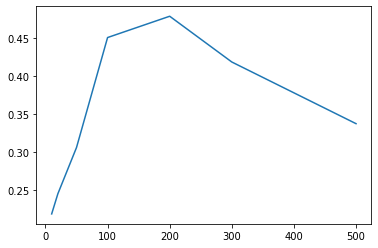

In [ ]:
plt.plot(num_topics,coherence_scores)

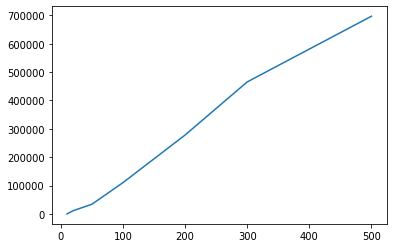

In [ ]:
plt.plot(num_topics,[i/1024 for i in memory])

[24.236774, 34.32916, 41.432735, 46.08656, 55.966023, 73.029283, 97.49084, 138.268226]
[10.092386000000001, 7.103574999999999, 4.653824999999998, 9.879463000000001, 17.063260000000007, 24.461557, 40.77738599999999]


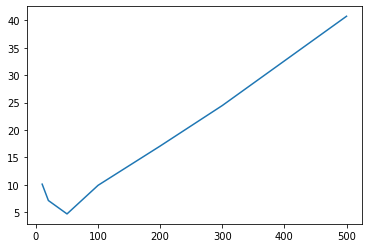

In [ ]:
times_taken=[]

for idx, time in enumerate(usertime):
  if len(usertime) > idx+1:
    time_taken=usertime[idx+1]-time
    times_taken.append(time_taken)

print(usertime)
print(times_taken)

plt.plot(num_topics[:],times_taken)

In [ ]:
for idx, model in enumerate(models):
  pd_model=get_lda_topics(model, 10)
  print(pd_model)

  Topic # 01 Topic # 02 Topic # 03  Topic # 04   Topic # 05   Topic # 06  \
0     police     people    vaccine         nsw  coronavirus         case   
1      trump   morrison   tasmania      donald       change  coronavirus   
2        man      house   bushfire      family          new        china   
3      woman        afl     school          sa   quarantine         news   
4      court     island        nsw     federal       market          new   
5      death      hotel        ban        care     brisbane        state   
6   national    missing    student  indigenous      concern       health   
7  melbourne      local     worker        aged      testing            ;   
8     murder     darwin      beach    regional         rise         live   
9      found      price       risk      update       travel        covid   

    Topic # 07   Topic # 08   Topic # 09 Topic # 10  
0          say   queensland        covid  australia  
1   australian   government           19     record  
2

In [ ]:
for idx, model  in enumerate(models):
  count=0
  for line in headlines['final_processed']: # where each line in the document is its own sentence for simplicity
    if count<10:
      word_dict = {};
      line_split=line.split()
      line_bow = id2word.doc2bow(line_split)
      doc_lda = model[line_bow]
      if(round(max(doc_lda)[1]*100,2)>80):
        count=count+1
        print('\nSentence: ', line)
        print( 'assigned to Topic ' + str(max(doc_lda)[0]) + ' with ' + str(round(max(doc_lda)[1]*100,2)) + ' probability!' + 'trained on model with ' + str(num_topics[idx]) + ' topics')
        words = model.show_topic(max(doc_lda)[0], topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(max(doc_lda)[0])] = [i[0] for i in words];
        pd.DataFrame(word_dict)
        print(word_dict)



Sentence:  esso responsible economic loss gas
assigned to Topic 9 with 85.0 probability!trained on model with 10 topics
{'Topic # 09': ['australia', 'record', 'world', 'sydney', 'canberra', 'show', 'andrew', 'return', 'close', 'open']}

Sentence:  ganguly lead india victory
assigned to Topic 9 with 82.0 probability!trained on model with 10 topics
{'Topic # 09': ['australia', 'record', 'world', 'sydney', 'canberra', 'show', 'andrew', 'return', 'close', 'open']}

Sentence:  hagan blood rookie penrith
assigned to Topic 9 with 82.0 probability!trained on model with 10 topics
{'Topic # 09': ['australia', 'record', 'world', 'sydney', 'canberra', 'show', 'andrew', 'return', 'close', 'open']}

Sentence:  schmeichel set miss arsenal trip
assigned to Topic 9 with 85.0 probability!trained on model with 10 topics
{'Topic # 09': ['australia', 'record', 'world', 'sydney', 'canberra', 'show', 'andrew', 'return', 'close', 'open']}

Sentence:  lovenkrands dreaming hampden return
assigned to Topic 9 wi